In [1]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import pandas as pd

%matplotlib inline

In [75]:
# Black-Scholes European Call Option
def Call(S, K, r, sigma,delta, t):
    
    d1 = (np.log(S/K) + r - delta + 0.5*np.power(sigma,2)*t) / (sigma*np.sqrt(t))
    print(d1)
    d2 = d1 - sigma*np.sqrt(t)
    
    return S*norm.cdf(d1) - K*np.exp(-r*t)*norm.cdf(d2)

def Put(S, K, r, sigma, t):
    
    d1 = (np.log(S/K) + r + 0.5*np.power(sigma,2)*t) / (sigma*np.sqrt(t))
    d2 = d1 - sigma*np.sqrt(t)
    
    return K*np.exp(-r*t)*norm.cdf(-d2) - S*norm.cdf(-d1)

In [76]:
Call(50, 60, 0.08, 0.22, 0.06, 1)

-0.6278252581543391


2.2715140849177278

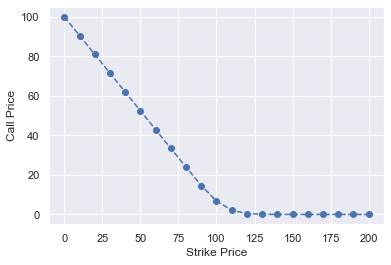

In [4]:
# Call price vs. strike price
S = 100
r = 0.05
sigma = 0.1
t = 1
K = [i for i in range(0, 201,10)]
K[0] = 1e-15 # Cannot be zero

prices = [Call(S, i, r, sigma, t) for i in K]

_ = plt.plot(K, prices, linestyle='--', marker='o')
_ = plt.xlabel("Strike Price")
_ = plt.ylabel("Call Price")

plt.savefig('call_vs_strike.pdf')

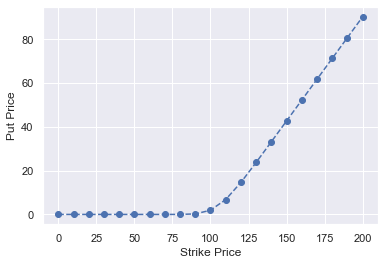

In [4]:
# Put price vs. strike price 
S = 100
r = 0.05
sigma = 0.1
t = 1
K = [i for i in range(0, 201,10)]
K[0] = 1e-15 # Cannot be zero

prices = [Put(S, i, r, sigma, t) for i in K]

_ = plt.plot(K, prices, linestyle='--', marker='o')
_ = plt.xlabel("Strike Price")
_ = plt.ylabel("Put Price")

plt.savefig('put_vs_strike.pdf')

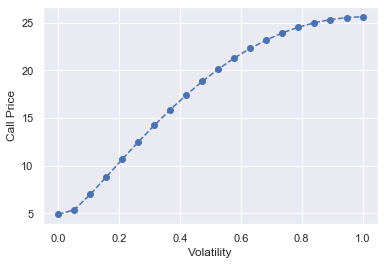

In [8]:
# Volatility and Price Relationship
S = 100
r = 0.05
t = 1
K = 100
sigma = np.linspace(0,1,20)
sigma[0] = 1e-15 # Cannot be zero

prices = [Call(S, K, r, i, t) for i in sigma]

_ = plt.plot(sigma, prices, linestyle='--', marker='o')
_ = plt.xlabel("Volatility")
_ = plt.ylabel("Call Price")

plt.savefig("vol_vs_strike.pdf")

In [5]:
# Delta hedging 
def delta_call(S, K, r, sigma, t):
    
    d1 = (np.log(S/K) + (r - 0.5*np.power(sigma,2))*t) / (sigma*t)
    
    return np.exp(-t)*norm.cdf(d1)

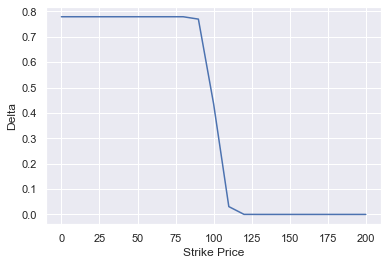

In [6]:
# Delta hedge example 
S = 100
r = 0.05
sigma = 0.2
t = 0.25
k = [i for i in range(0, 201, 10)]
k[0] = 1e-15 #Cannot be zero
deltas = [delta_call(S, i, r, sigma, t) for i in k]
_ = plt.plot(k, deltas)
_ = plt.xlabel("Strike Price")
_ = plt.ylabel("Delta")

plt.savefig('delta.pdf')

In [63]:
'''
(1) Simulate future stock prices 
(2) Calculate expected payoff for option
(3) Option price = PV(Expected payoff)
'''

class SimulateOptions:
    
    def __init__(self, S, K, m, v, t, sims, r):
        
        self.S = S # Current price
        self.K = K # Strike price
        self.m = m # Expected daily return
        self.v = v # Variance of daily return
        self.t = t # Time in years
        self.sims = sims # Number of simulations to run
        self.r = r # Risk-free rate
    
    def simulate_price(self):
        '''
        Function to simulate future stock prices via Monte Carlo process
        
        Returns expected stock price at time t in the future 
        '''
        
        prices = []
    
        for sim in range(self.sims):
        
            future_prices = self.S * (1 + np.random.normal(self.m, self.v, int(self.t*365))).cumprod()
            prices.append(future_prices[-1])
    
        return np.mean(prices)
    
    def expected_payoff(self):
        '''
        Function to calculate expected payoff of a European call option,
        given the expected value of the simulated stock prices. 
        '''
    
        expected_price = self.simulate_price()
    
        if expected_price > self.K:
            
            return expected_price - self.K
        
        else:
            
            return 0 

    def present_value(self):
        '''
        Function to present value the expected payoff using the time
        and the risk-free rate.
        '''
        
        payoff = self.expected_payoff()
        
        return payoff * np.exp(-self.r * self.t)

In [66]:
S = 100
K = 100
m = 0.0001
v = 0.01
sims = 10000
r = 0.03
t = [0.25*i for i in range(1,21)]

data = pd.DataFrame()

bs_results = [Call(S, K, r, v, i) for i in t]
sim_results = [SimulateOptions(S, K, m,v,i,sims,r).present_value() for i in t]

data['t'] = t
data['BSM'] = bs_results
data['Sim'] = sim_results
data['|Error|'] = abs(data.BSM - data.Sim)
data = data.set_index('t')

In [67]:
data

,BSM,Sim,|Error|
t,,,
0.25,0.747195,0.872103,0.124909
0.50,1.488824,1.777249,0.288424
0.75,2.225131,2.750775,0.525644
1.00,2.955823,3.673704,0.717880
1.25,3.679104,4.047075,0.367972
1.50,4.392565,4.986493,0.593928
1.75,5.094171,6.061587,0.967416
2.00,5.782575,6.768215,0.985640
2.25,6.457058,8.290518,1.833459


In [28]:
class OptionGreeks:

    def __init__(self, option, S, K, r, t, sigma):
      
        self.option = option
        self.S = S
        self.K = K
        self.r = r
        self.t = t
        self.sigma = sigma
        self.d1 = (np.log(self.S/self.K) + (self.r + 0.5 * self.sigma ** 2) * self.t) / (self.sigma*np.sqrt(self.t))
        self.d2 = self.d1 - self.sigma*np.sqrt(self.t)
        
    def n_prime(self, x):
        
        self.x = x

        return (2 * np.pi) ** -0.5 * np.exp(-0.5 * self.x ** 2)

    def delta(self):

        if self.option == "call":

            return norm.cdf(self.d1)

        else:

            return -norm.cdf(-self.d1)

    def gamma(self):

        return self.n_prime(self.d1) / (self.S * self.sigma * np.sqrt(self.t))

    def theta(self):

        theta_call = ((-self.sigma * self.S * self.n_prime(self.d1)) / (2 * np.sqrt(self.t))) - \
                        (self.r*self.K*np.exp(-self.r*self.t)*norm.cdf(self.d2))
        
        if self.option == "call":

            return theta_call

        else:

            return theta_call + (self.r*self.K*np.exp(-self.r*self.t))

    def vega(self):

        return (self.S*np.sqrt(self.t) * self.n_prime(self.d1)) / 100

    def rho(self):

        if self.option == "call":

            return (self.K*self.t*np.exp(-self.r*self.t)*norm.cdf(self.d2)) / 100

        else:

            return (-self.K*self.t*np.exp(-self.r*self.t)*norm.cdf(-self.d2)) / 100


In [29]:
a = OptionGreeks("call", 100, 110, .05, 1, .25)
greeks = [a.delta(), a.gamma(), a.theta(), a.vega(), a.rho()]